# Comparing a LSTM, GRU, and RNN network for regressing prices of SPY US Equity
 (Also hopefully a transformer model in another file)

In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd


spy = pd.read_csv('newdata/AAPL.csv')
spy.head()

,ticker,AAPL US Equity,AAPL US Equity.1,AAPL US Equity.2,AAPL US Equity.3,AAPL US Equity.4,Close Tomorrow
0,field,PX_LAST,PX_OPEN,MOV_AVG_200D,MOV_AVG_5D,MOV_AVG_50D,NaN
1,date,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,0.999,0.936,0.5644,0.9177,0.8455,0.915
3,2000-01-04,0.915,0.967,0.5675,0.9254,0.8506,0.929
4,2000-01-05,0.929,0.926,0.5706,0.9314,0.8559,0.848


## Data Preparation

In [2]:
dataDate = spy.loc[:, 'ticker'].values
dataLastPrice = spy.loc[:, 'AAPL US Equity'].values

# pop junk out of here
dataDate = dataDate[2:]
dataLP = dataLastPrice[2:].astype(float)

In [3]:
class Transformations():
    def __init__(self):
        self.mu = None
        self.sd = None

    def normalize(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        return (x-self.mu)/self.sd

    def inverseNormalize(self, x):
        return x*self.sd + self.mu

transformer = Transformations()
normLP = transformer.normalize(dataLP)

In [4]:
def prepare_data_x(x, window_size):
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, 20)
    data_y = prepare_data_y(normalized_data_close_price, 20)

    # split dataset

    split_index_train_val = int(data_y.shape[0]*0.6)
    split_index_val_test = int(data_y.shape[0]*0.6) + int(data_y.shape[0]*0.2)
    data_x_train = data_x[:split_index_train_val]
    data_x_val = data_x[split_index_train_val:split_index_val_test]
    data_x_test = data_x[split_index_val_test:]

    data_y_train = data_y[:split_index_train_val]
    data_y_val = data_y[split_index_train_val:split_index_val_test]
    data_y_test = data_y[split_index_val_test:]

    return split_index_train_val, data_x_train, data_y_train, data_x_val, data_y_val, data_x_test, data_y_test, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_test, data_y_test, data_x_unseen = prepare_data(normLP)

Next, we need to create our training, validation and testing sets:

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)
dataset_test = TimeSeriesDataset(data_x_test, data_y_test)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
print("Testing data shape", dataset_test.x.shape, dataset_test.y.shape)

Train data shape (3451, 20, 1) (3451,)
Validation data shape (1150, 20, 1) (1150,)
Testing data shape (1152, 20, 1) (1152,)


# The LSTM Model

In [6]:
class LSTMModel(nn.Module):
    
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]


input_size = 1 # sine we are only using 1 feature, close price
num_lstm_layers = 3
lstm_size =  32
dropout = 0.2
lstmModel = LSTMModel(input_size=input_size, hidden_layer_size=lstm_size, num_layers=num_lstm_layers, output_size=1, dropout=dropout)
lstmModel = lstmModel.to('cpu')

### Train the LSTM Model

In [7]:
# hyper parameters
batch_size = 16

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

learning_rate = 0.01
sched_step_size = 40
criterion = nn.MSELoss()
optimizer = optim.Adam(lstmModel.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=sched_step_size, gamma=0.1)

num_epochs = 50


overallLSTMTrainLoss = []
overallLSTMValLoss = []
for epoch in range(num_epochs):
    train_losses = []
    val_losses = []
    lstmModel.train()
    for idx, (x_batch, y_batch) in enumerate(train_dataloader):

        optimizer.zero_grad()

        out = lstmModel(x_batch)

        loss = criterion(out.contiguous(), y_batch.contiguous())

        loss.backward()
        optimizer.step()

        batchsize = x_batch.shape[0]
        train_losses.append(loss.detach().item() / batchsize)
        
    overallLSTMTrainLoss.append(sum(train_losses))

    lstmModel.eval()
    for idx, (x_batch, y_batch) in enumerate(val_dataloader):
        
        out = lstmModel(x_batch)
        
        loss = criterion(out.contiguous(), y_batch.contiguous())
        batchsize = x_batch.shape[0]
        val_losses.append(loss.detach().item() / batchsize)

    overallLSTMValLoss.append(sum(val_losses))

    scheduler.step()

    print('Epoch[{}/{}] train loss:{:.6f}, val loss:{:.6f}'
            .format(epoch+1, num_epochs, sum(train_losses), sum(val_losses)))

Epoch[1/50] train loss:0.081615, val loss:0.172387
Epoch[2/50] train loss:0.015551, val loss:0.135034
Epoch[3/50] train loss:0.006615, val loss:0.143755
Epoch[4/50] train loss:0.005137, val loss:0.154000
Epoch[5/50] train loss:0.003774, val loss:0.158957
Epoch[6/50] train loss:0.003463, val loss:0.146259
Epoch[7/50] train loss:0.003389, val loss:0.059490
Epoch[8/50] train loss:0.003193, val loss:0.150823
Epoch[9/50] train loss:0.003758, val loss:0.072864
Epoch[10/50] train loss:0.002897, val loss:0.092286
Epoch[11/50] train loss:0.002898, val loss:0.088043
Epoch[12/50] train loss:0.002554, val loss:0.091776
Epoch[13/50] train loss:0.002512, val loss:0.117145
Epoch[14/50] train loss:0.002577, val loss:0.093394
Epoch[15/50] train loss:0.002108, val loss:0.151921
Epoch[16/50] train loss:0.002372, val loss:0.075990
Epoch[17/50] train loss:0.002512, val loss:0.056527
Epoch[18/50] train loss:0.002794, val loss:0.068453
Epoch[19/50] train loss:0.002665, val loss:0.052485
Epoch[20/50] train lo

### Plot Loss curves for LSTM Training

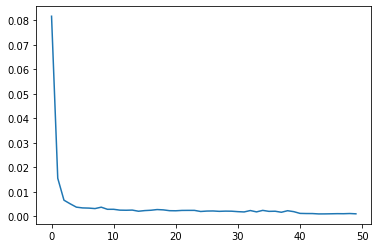

In [8]:
plt.plot(overallLSTMTrainLoss)

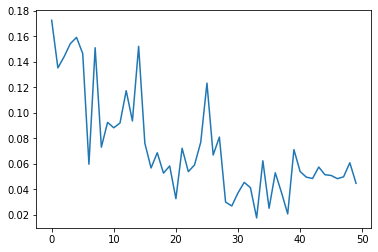

In [9]:
plt.plot(overallLSTMValLoss)

# RNN Model

In [10]:

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        
        return self.fc(out)[:, -1]


input_size = 1 # sine we are only using 1 feature, close price
num_rnn_layers = 3
rnn_size =  64
dropout = 0.2
rnnModel = RNNModel(input_dim=input_size, hidden_dim=rnn_size, layer_dim=num_rnn_layers, output_dim=1, dropout_prob=dropout)


### Train the RNN Model

In [11]:
# hyper parameters
batch_size = 16

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

learning_rate = 0.001
sched_step_size = 25
criterion = nn.MSELoss()
optimizer = optim.Adam(rnnModel.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=sched_step_size, gamma=0.1)

num_epochs = 50


overallRNNTrainLoss = []
overallRNNValLoss = []
for epoch in range(num_epochs):
    train_losses = []
    val_losses = []
    rnnModel.train()
    for idx, (x_batch, y_batch) in enumerate(train_dataloader):

        optimizer.zero_grad()

        out = rnnModel(x_batch)

        loss = criterion(out.contiguous(), y_batch.contiguous())

        loss.backward()
        optimizer.step()

        batchsize = x_batch.shape[0]
        train_losses.append(loss.detach().item() / batchsize)
        
    overallRNNTrainLoss.append(sum(train_losses))

    rnnModel.eval()
    for idx, (x_batch, y_batch) in enumerate(val_dataloader):
        
        out = rnnModel(x_batch)
        
        loss = criterion(out.contiguous(), y_batch.contiguous())
        batchsize = x_batch.shape[0]
        val_losses.append(loss.detach().item() / batchsize)

    overallRNNValLoss.append(sum(val_losses))

    scheduler.step()

    print('Epoch[{}/{}] train loss:{:.6f}, val loss:{:.6f}'
            .format(epoch+1, num_epochs, sum(train_losses), sum(val_losses)))

Epoch[1/50] train loss:0.100493, val loss:0.005132
Epoch[2/50] train loss:0.007169, val loss:0.017976
Epoch[3/50] train loss:0.005334, val loss:0.021206
Epoch[4/50] train loss:0.004612, val loss:0.035756
Epoch[5/50] train loss:0.004142, val loss:0.023745
Epoch[6/50] train loss:0.003178, val loss:0.012406
Epoch[7/50] train loss:0.003145, val loss:0.019530
Epoch[8/50] train loss:0.003117, val loss:0.058370
Epoch[9/50] train loss:0.003370, val loss:0.002797
Epoch[10/50] train loss:0.002932, val loss:0.009371
Epoch[11/50] train loss:0.003241, val loss:0.012958
Epoch[12/50] train loss:0.002371, val loss:0.021354
Epoch[13/50] train loss:0.002038, val loss:0.061164
Epoch[14/50] train loss:0.002511, val loss:0.010604
Epoch[15/50] train loss:0.002660, val loss:0.005562
Epoch[16/50] train loss:0.002066, val loss:0.021600
Epoch[17/50] train loss:0.002218, val loss:0.004504
Epoch[18/50] train loss:0.002357, val loss:0.021435
Epoch[19/50] train loss:0.002097, val loss:0.003855
Epoch[20/50] train lo

### Plot the training and validation loss for RNN Training

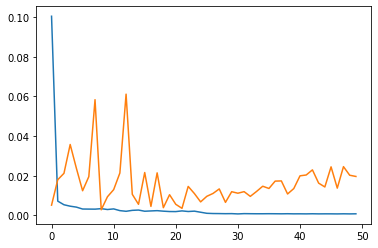

In [12]:
plt.plot(overallRNNTrainLoss)
plt.plot(overallRNNValLoss)

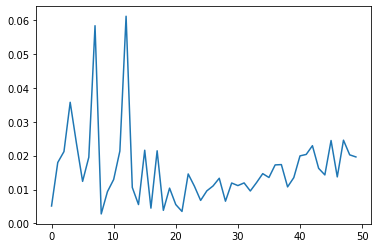

In [13]:
plt.plot(overallRNNValLoss)

# GRU Model

In [14]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        batchsize = x.shape[0]
        
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h_n= self.gru(x, h0.detach())
        ##x = h_n.permute(1, 0, 2).reshape(batchsize, -1)
        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)[:, -1]#out

        return out


input_size = 1 # sine we are only using 1 feature, close price
num_gru_layers = 3
gru_size =  64
dropout = 0.2
gruModel = GRUModel(input_dim=input_size, hidden_dim=gru_size, layer_dim=num_gru_layers, output_dim=1, dropout_prob=dropout)

In [15]:
# hyper parameters
batch_size = 16

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

learning_rate = 0.01
sched_step_size = 5
criterion = nn.MSELoss()
optimizer = optim.Adam(gruModel.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=sched_step_size, gamma=0.1)

num_epochs = 50


overallGRUTrainLoss = []
overallGRUValLoss = []
for epoch in range(num_epochs):
    train_losses = []
    val_losses = []
    gruModel.train()
    for idx, (x_batch, y_batch) in enumerate(train_dataloader):

        optimizer.zero_grad()

        out = gruModel(x_batch)
        #print(out.squeeze())
        #print(out.squeeze().size())
        #print(y_batch.squeeze())
        #if idx > 4:
        #    break
    
        loss = criterion(out.contiguous(), y_batch.contiguous())

        loss.backward()
        optimizer.step()

        batchsize = x_batch.shape[0]
        train_losses.append(loss.detach().item() / batchsize)
        
    overallGRUTrainLoss.append(sum(train_losses))
    #break
    gruModel.eval()
    for idx, (x_batch, y_batch) in enumerate(val_dataloader):
        
        out = gruModel(x_batch)
        loss = criterion(out.contiguous(), y_batch.contiguous())
        batchsize = x_batch.shape[0]
        val_losses.append(loss.detach().item() / batchsize)


    overallGRUValLoss.append(sum(val_losses))

    scheduler.step()

    print('Epoch[{}/{}] train loss:{:.6f}, val loss:{:.6f}'
            .format(epoch+1, num_epochs, sum(train_losses), sum(val_losses)))

Epoch[1/50] train loss:0.086771, val loss:0.012132
Epoch[2/50] train loss:0.005207, val loss:0.106989
Epoch[3/50] train loss:0.005371, val loss:0.034730
Epoch[4/50] train loss:0.004167, val loss:0.066371
Epoch[5/50] train loss:0.002821, val loss:0.015203
Epoch[6/50] train loss:0.001113, val loss:0.013841
Epoch[7/50] train loss:0.001011, val loss:0.019325
Epoch[8/50] train loss:0.001018, val loss:0.051009
Epoch[9/50] train loss:0.000970, val loss:0.016143
Epoch[10/50] train loss:0.000869, val loss:0.023651
Epoch[11/50] train loss:0.000661, val loss:0.027695
Epoch[12/50] train loss:0.000655, val loss:0.027589
Epoch[13/50] train loss:0.000622, val loss:0.027635
Epoch[14/50] train loss:0.000656, val loss:0.037608
Epoch[15/50] train loss:0.000625, val loss:0.042314
Epoch[16/50] train loss:0.000613, val loss:0.042029
Epoch[17/50] train loss:0.000636, val loss:0.041837
Epoch[18/50] train loss:0.000611, val loss:0.041396
Epoch[19/50] train loss:0.000619, val loss:0.042647
Epoch[20/50] train lo

### Plotting the Validation and Training Losses for GRU Training

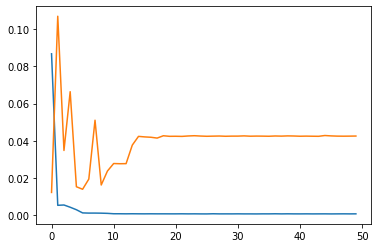

In [16]:
plt.plot(overallGRUTrainLoss)
plt.plot(overallGRUValLoss)

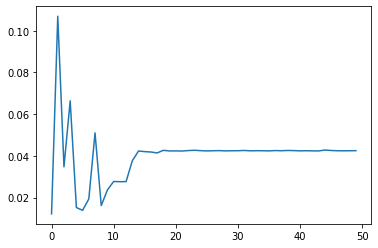

In [17]:
plt.plot(overallGRUValLoss)

# Comparision of the three models *graphically*

In [18]:
def plotsForModel(model, modelType):

    import warnings
    warnings.filterwarnings("ignore")
    num_data_points = len(data_x_train) + len(data_x_val)

    train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
    val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
    xticks_interval =  90
    color_actual = "#001f3f"
    color_train = "#3D9970"
    color_val = "#0074D9"
    color_pred_train= "#3D9970"
    color_pred_val = "#0074D9"
    color_pred_test = "#FF4136"


    model.eval()

    # predict on the training data, to see how well the model managed to learn and memorize

    predicted_train = np.array([])

    for idx, (x, y) in enumerate(train_dataloader):
        out = model(x)
        out = out.cpu().detach().numpy()
        out = out.squeeze()

        predicted_train = np.concatenate((predicted_train, out))

    # predict on the validation data, to see how the model does
    predicted_val = np.array([])

    for idx, (x, y) in enumerate(val_dataloader):
        out = model(x)

        out = out.cpu().detach().numpy()
        out = out.squeeze()
        predicted_val = np.concatenate((predicted_val, out))


    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)
    to_plot_data_y_train_pred[0:split_index] = transformer.inverseNormalize(predicted_train)
    to_plot_data_y_val_pred[split_index:] = transformer.inverseNormalize(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(dataDate[:num_data_points], dataLP[:num_data_points], label="Actual prices", color=color_actual)
    plt.plot(dataDate[:num_data_points], to_plot_data_y_train_pred, label="Predicted prices (train)", color=color_pred_train)
    plt.plot(dataDate[:num_data_points], to_plot_data_y_val_pred, label="Predicted prices (validation)", color=color_pred_val)
    plt.title("Compare predicted prices to actual prices for " + modelType + ' model')
    xticks = [dataDate[i] if ((i%xticks_interval==0 and (num_data_points-i) > xticks_interval) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation

    to_plot_data_y_val_subset = transformer.inverseNormalize(data_y_val)
    to_plot_predicted_val = transformer.inverseNormalize(predicted_val)
    to_plot_data_date = dataDate[split_index:num_data_points]

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=color_actual)
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=color_pred_val)
    plt.title("Zoom in to examine predicted price on validation data portion for " + modelType + ' model')
    xticks = [to_plot_data_date[i] if ((i%int(xticks_interval/5)==0 and (len(to_plot_data_date)-i) > xticks_interval/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

## LSTM On Data:

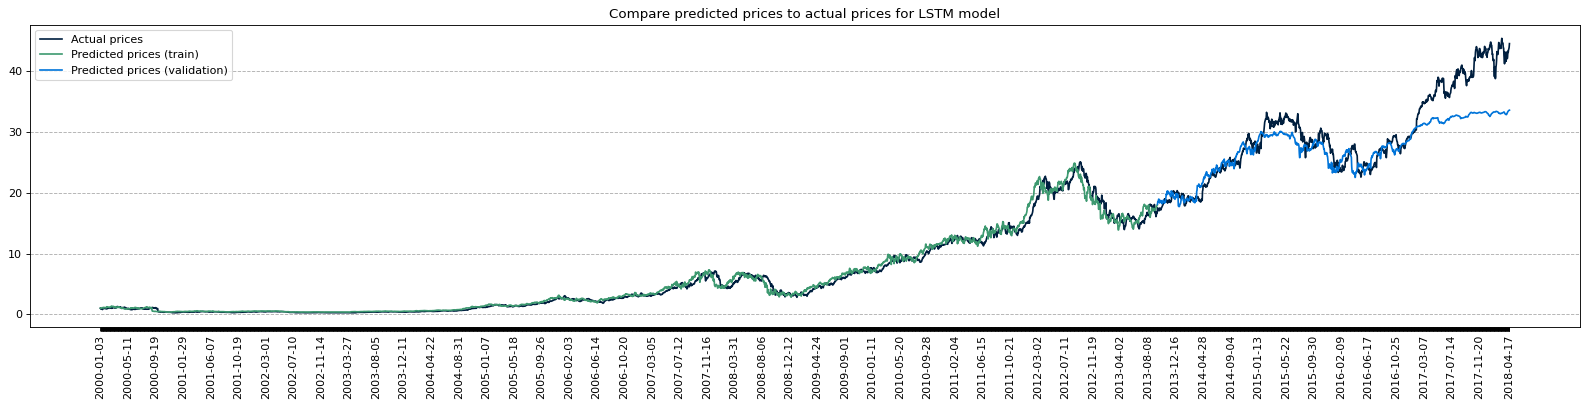

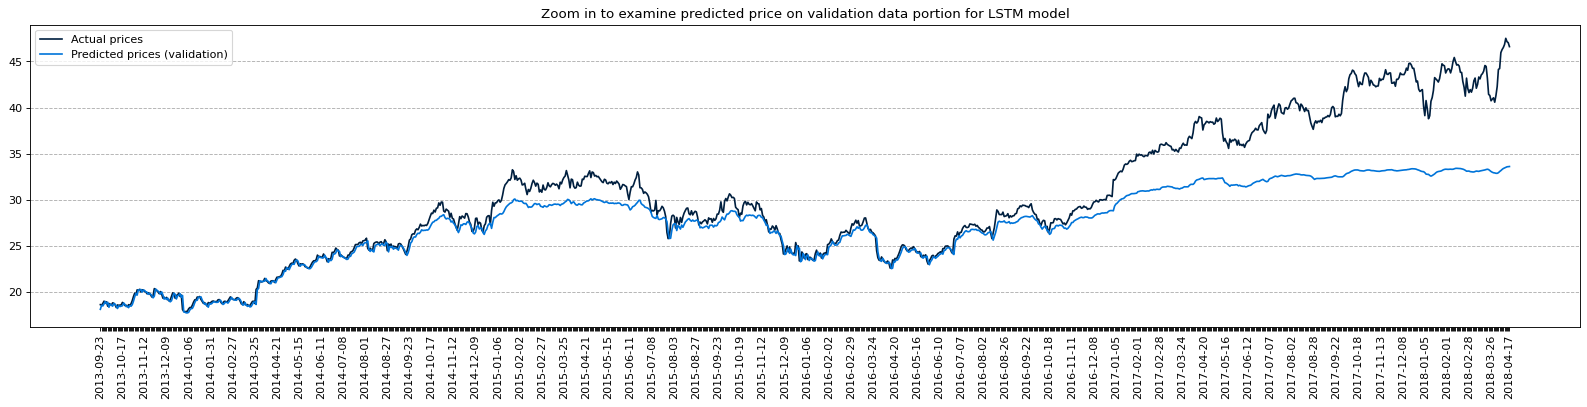

In [19]:
plotsForModel(lstmModel, 'LSTM')

## RNN On Data:

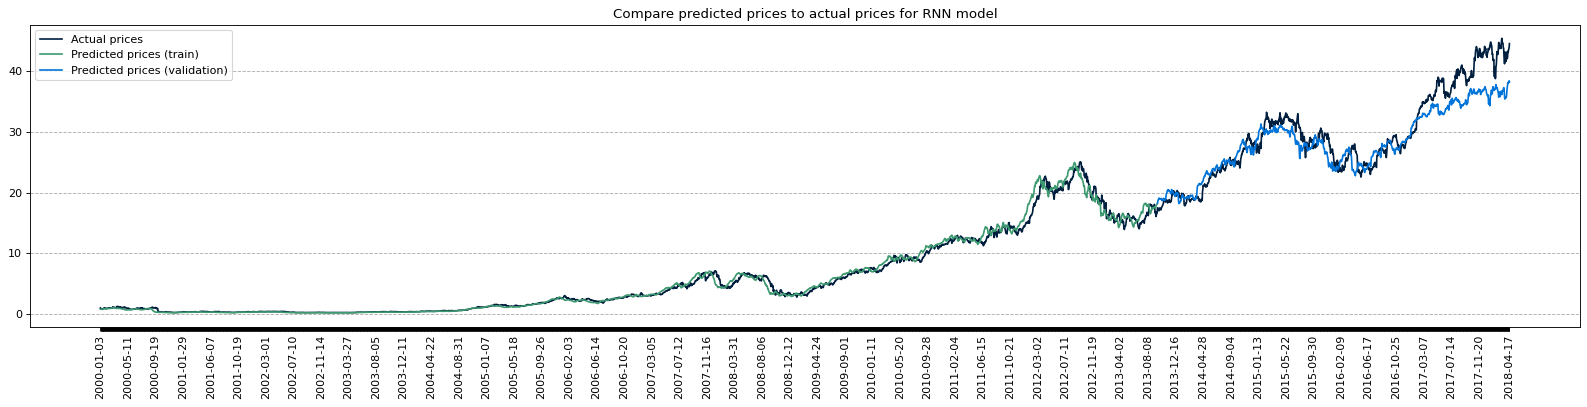

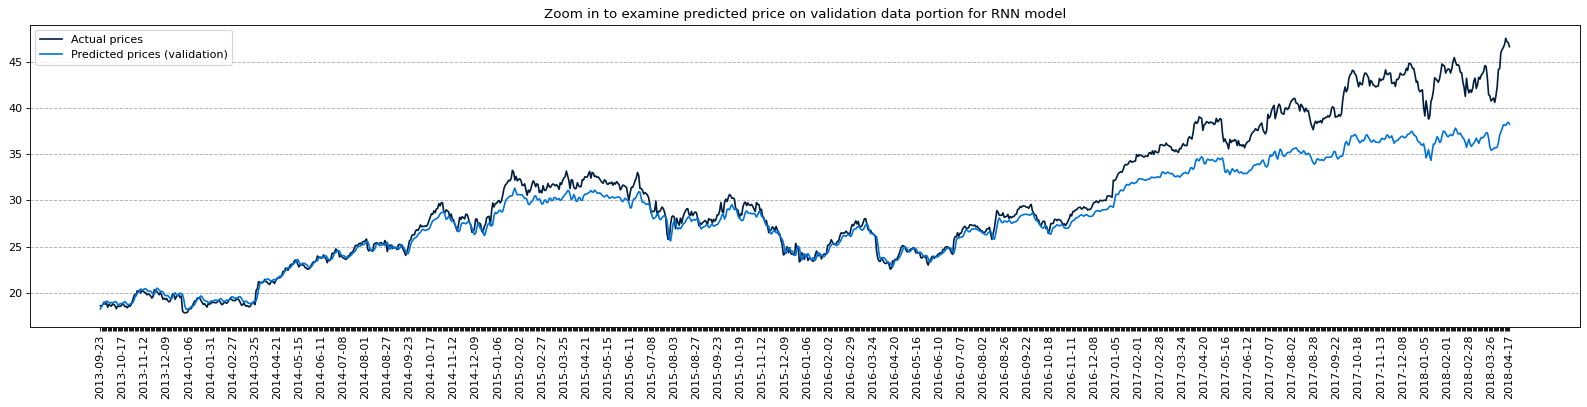

In [20]:
plotsForModel(rnnModel, 'RNN')

## GRU On Data:

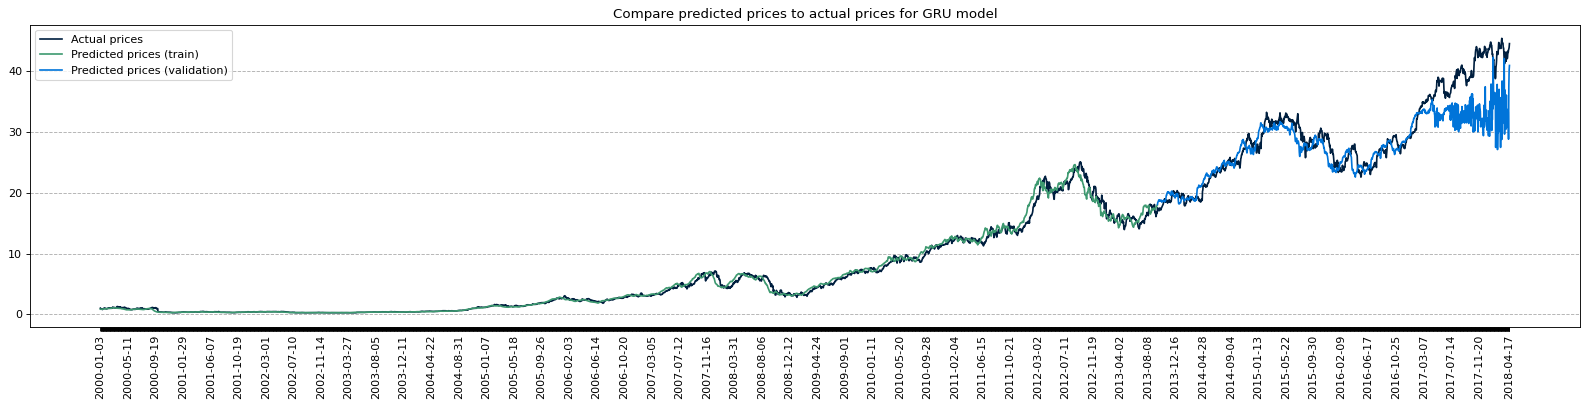

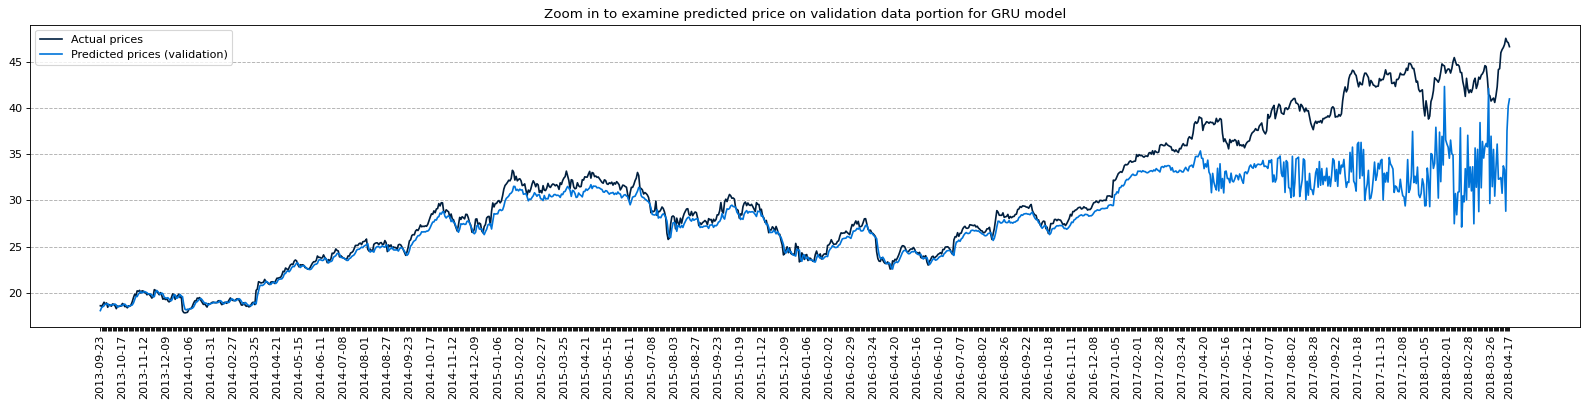

In [21]:
with torch.no_grad():
    plotsForModel(gruModel, 'GRU')

### When I am all done... the TEST SET